<a href="https://colab.research.google.com/github/Shashwat17-vit/STAT453_GANs/blob/main/GoodFellowGANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple GANS on MNIST dataset

In [1]:
#!pip install tensorflow # Run for TPU

In [8]:
import tensorflow as tf
import numpy as np
import os
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def show_images_cifar(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([8,4]))
    return

def show_images_cifar_org(images1):
    for i, img in enumerate(images1):
        plt.axis('off')
        plt.imshow(images1)
    return


def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.shape) for p in model.weights])
    return param_count

#answers = np.load('../input/cs231n-gan/gan-checks-tf.npz')

NOISE_DIM = 96

# Download and load MNIST dataset

In [5]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the MNIST data

        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, _ = tf.keras.datasets.mnist.load_data()
        X, y = train
        self.show_images_cifar_org(X)
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))

In [62]:
train= tfds.load('cifar10', split=['train', 'test'], as_supervised=True)


In [14]:
class STL10(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the CIFAR data

        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """

        #cifar10 = tf.keras.datasets.cifar10

        ds_train, ds_test = tfds.load('stl10', split=['train', 'test'], as_supervised=True)

        images_only = ds_train.map(lambda image, label: image)

        x_train, x_test = x_train / 255.0, x_test / 255.0


        # Combine both training and test sets into one dataset
        train = np.concatenate([x_train, x_test], axis=0)
        print(train[0].shape)
        green_channel = train[..., 1]


        X, y , *_ = green_channel
        X = X.astype(np.float32)
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle
        print(X[0])

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))

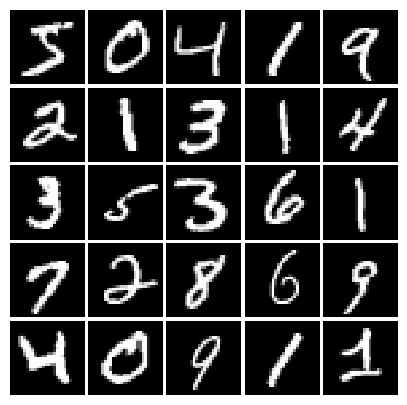

In [54]:
# show a batch
mnist = MNIST(batch_size=25)
show_images(mnist.X[:25])

## Save Model


In [68]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Load CelebA dataset
celeb_a_ds = tfds.load('celeb_a', split='train', as_supervised=True)

# Resize images to 32x32
celeb_a_resized = celeb_a_ds.map(lambda img, label: (tf.image.resize(img, [32, 32]), label))

# Extract only images
celeb_a_images = celeb_a_resized.map(lambda img, label: img)

# Convert to list (Optional)
images_list = list(celeb_a_images.as_numpy_iterator())

# Print first image shape
print("First image shape:", images_list[0].shape)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

NonMatchingChecksumError: Artifact https://drive.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM, downloaded to /root/tensorflow_datasets/downloads/celeb_a/ucexport_download_id_0B7EVK8r0v71pZjFTYXZWM3FlDDaXUAQO8EGH_a7VqGNLRtW52mva1LzDrb-V723OQN8.tmp.f9a43cfd1052413eae1b2ac109209618/download, has wrong checksum:
* Expected: UrlInfo(size=1.34 GiB, checksum='46fb89443c578308acf364d7d379fe1b9efb793042c0af734b6112e4fd3a8c74', filename='img_align_celeba.zip')
* Got: UrlInfo(size=2.37 KiB, checksum='e596a59036bdb8074069e5e607f866ec04a29efe8505768c66a4d3d9d309ff31', filename='download')
To debug, see: https://www.tensorflow.org/datasets/overview#fixing_nonmatchingchecksumerror

First image shape: (96, 96, 3)


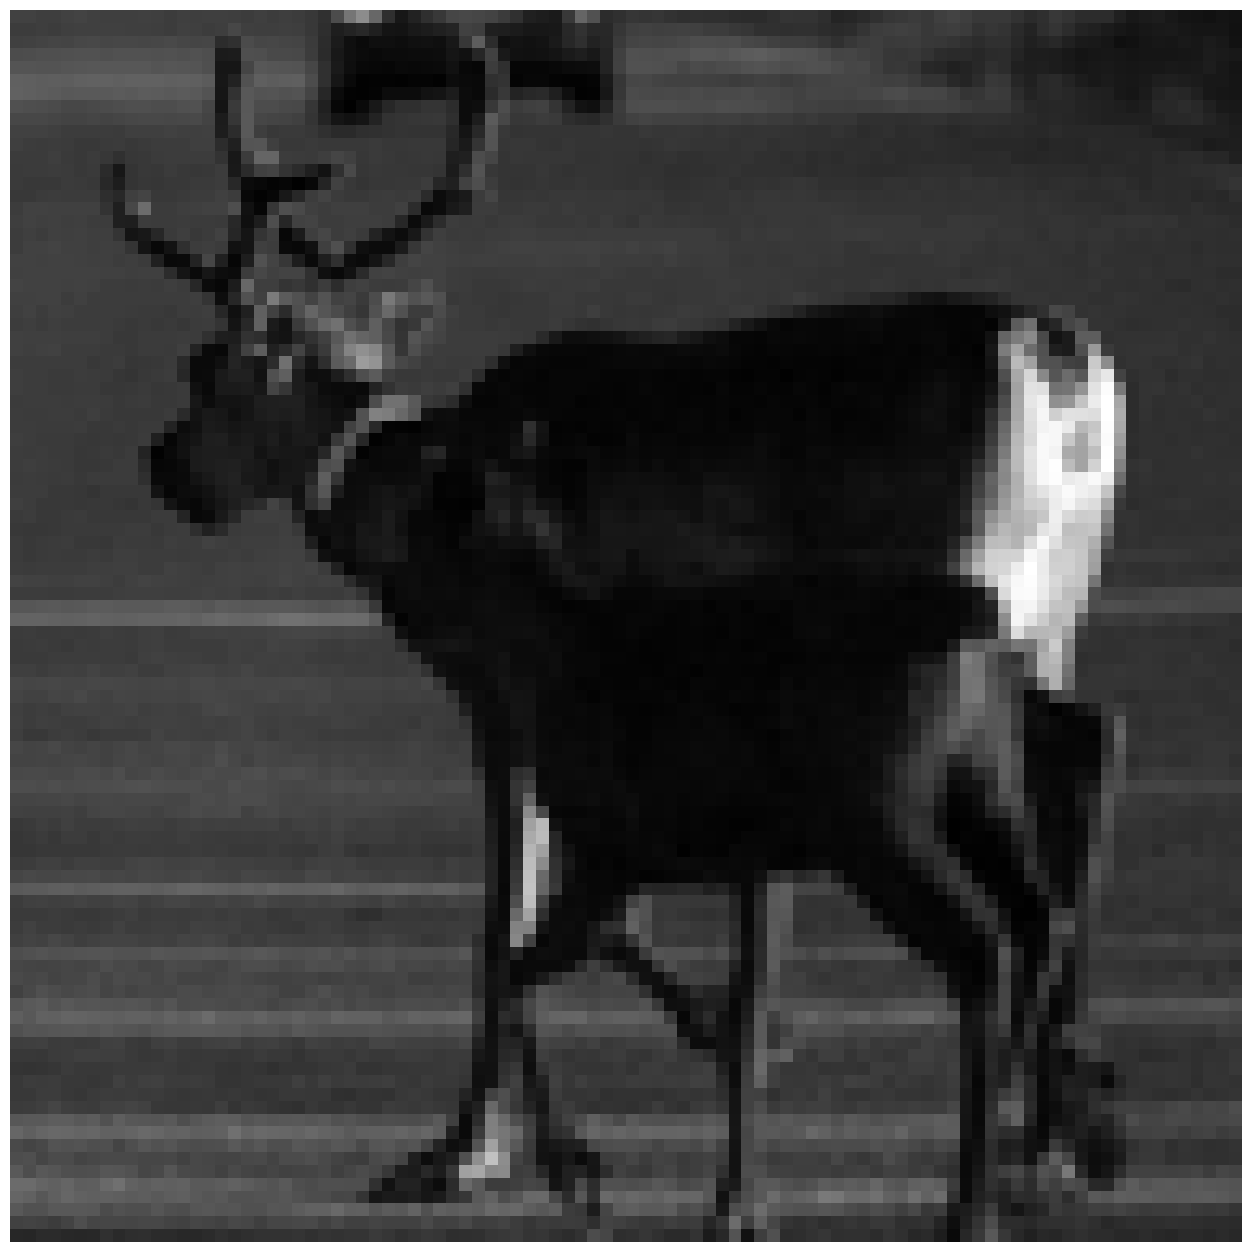

In [61]:

# Map the dataset to extract just the images
images_only = ds_train.map(lambda image, label: image)

# Then, if you need a Python list:
images_list = list(images_only.as_numpy_iterator())
images_array = np.array(images_list, dtype=np.float32)

# Check the first image
print("First image shape:", images_array[0].shape)
show_images_cifar_org(images_array[25][...,0])
#show_images_cifar(cifar.X[:25])

# Activation function Leaky_Relu or others

In [5]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.

    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU

    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    x = tf.nn.leaky_relu(x,alpha)
    return x
    pass

## Create Noise for Input

In [6]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.

    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the noise to generate

    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    noise = tf.random.uniform([batch_size,dim],minval = -1,maxval = 1)
    return noise
    pass

## Check if all the noises created have proper format and condition (use assert exception)

In [7]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    z = sample_noise(batch_size, dim)
    # Check z has the correct shape
    assert z.get_shape().as_list() == [batch_size, dim]
    # Make sure z is a Tensor and not a numpy array
    assert isinstance(z, tf.Tensor)
    # Check that we get different noise for different evaluations
    z1 = sample_noise(batch_size, dim)
    z2 = sample_noise(batch_size, dim)
    assert not np.array_equal(z1, z2)
    # Check that we get the correct range
    assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
    print("All tests passed!")

test_sample_noise()

All tests passed!


## A fully connected layer for Discriminator

In [8]:
def discriminator():
    """Compute discriminator score for a batch of input images.

    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]

    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score
    for an image being real for each input image.
    """
    model = tf.keras.models.Sequential([
        # TODO: implement architecture
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        tf.keras.layers.InputLayer((1024,)),
        tf.keras.layers.Dense(256),
        tf.keras.layers.LeakyReLU(0.01),
        tf.keras.layers.Dense(256),
        tf.keras.layers.LeakyReLU(0.01),
        tf.keras.layers.Dense(1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ])
    return model

In [9]:
# Optional check Number of Parameters created matches out expectation :

def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in discriminator.')

test_discriminator()

Correct number of parameters in discriminator.


## Creating a generator model

In [10]:
def generator(noise_dim=NOISE_DIM):
    """Generate images from a random noise vector.

    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]

    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    model = tf.keras.models.Sequential([
        # TODO: implement architecture
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        tf.keras.layers.InputLayer((noise_dim,)),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(1024,activation = tf.nn.tanh)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ])
    return model

In [11]:
# Optional to test the generator model parameters
def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in generator.')

test_generator()

Correct number of parameters in generator.


## Prepare the loss function of GAN Loss, we can use other loss funtions aswell

In [12]:
# The Generator loss is aimed to maximize the incorrect predictions by the Discrimiator .. We want to fool the discriminator:
def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.

    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    loss = None
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    loss = cross_entropy(tf.ones_like(logits_fake), logits_fake)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

  # The Discriminator tries to maximizes its correct predictions

def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.

    Inputs:
    - logits_real: Tensor of shape (N, 1) giving scores for the real data.
    - logits_fake: Tensor of shape (N, 1) giving scores for the fake data.

    Returns:
    - loss: Tensor containing (scalar) the loss for the discriminator.
    """
    loss = None
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    real_loss = cross_entropy(tf.ones_like(logits_real), logits_real)
    fake_loss = cross_entropy(tf.zeros_like(logits_fake), logits_fake)
    loss = real_loss + fake_loss
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

## Optimize our D and G losses defined above.. We dont want the D losses to minimize to zero so quickly that G does not learn.
### So we often use SGD + Momentum

In [13]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.

    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)

    Returns:
    - D_solver: instance of tf.optimizers.Adam with correct learning_rate and beta1
    - G_solver: instance of tf.optimizers.Adam with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    D_solver = tf.optimizers.Adam(learning_rate,beta1)
    G_solver = tf.optimizers.Adam(learning_rate,beta1)
    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return D_solver, G_solver

## Train you GAN on MNIST

In [16]:
# a giant helper function
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss,\
              show_every=20, print_every=20, batch_size=128, num_epochs=7, noise_size=96):
    """Train a GAN for a certain number of epochs.

    Inputs:
    - D: Discriminator model
    - G: Generator model
    - D_solver: an Optimizer for Discriminator
    - G_solver: an Optimizer for Generator
    - generator_loss: Generator loss
    - discriminator_loss: Discriminator loss
    Returns:
        Nothing
    """
    mnist = MNIST(batch_size=batch_size, shuffle=True)
    mnist = CIFAR(batch_size=batch_size, shuffle=True)

    iter_count = 0
    for epoch in range(num_epochs):
        for (x, _) in mnist:
            with tf.GradientTape() as tape:
                real_data = x
                logits_real = D(preprocess_img(real_data))

                g_fake_seed = sample_noise(batch_size, noise_size)
                fake_images = G(g_fake_seed)
                logits_fake = D(tf.reshape(fake_images, [batch_size, 784]))

                d_total_error = discriminator_loss(logits_real, logits_fake)
                d_gradients = tape.gradient(d_total_error, D.trainable_variables)
                D_solver.apply_gradients(zip(d_gradients, D.trainable_variables))

            with tf.GradientTape() as tape:
                g_fake_seed = sample_noise(batch_size, noise_size)
                fake_images = G(g_fake_seed)

                gen_logits_fake = D(tf.reshape(fake_images, [batch_size, 784]))
                g_error = generator_loss(gen_logits_fake)
                g_gradients = tape.gradient(g_error, G.trainable_variables)
                G_solver.apply_gradients(zip(g_gradients, G.trainable_variables))

            if (iter_count % show_every == 0):
                print('Epoch: {}, Iter: {}, D: {:.4}, G:{:.4}'.format(epoch, iter_count,d_total_error,g_error))
                imgs_numpy = fake_images.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
            iter_count += 1

    # random noise fed into our generator
    z = sample_noise(batch_size, noise_size)
    # generated images
    G_sample = G(z)
    print('Final images')
    show_images(G_sample[:16])
    plt.show()

Epoch: 0, Iter: 0, D: 1.195, G:0.7456


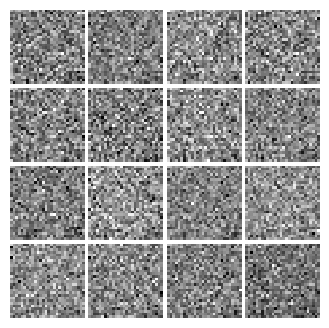

Epoch: 0, Iter: 20, D: 0.5634, G:1.013


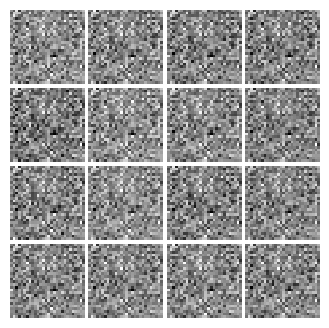

Epoch: 0, Iter: 40, D: 0.434, G:1.315


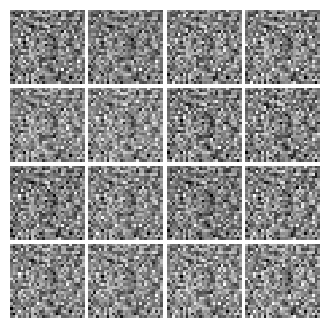

Epoch: 0, Iter: 60, D: 2.052, G:2.536


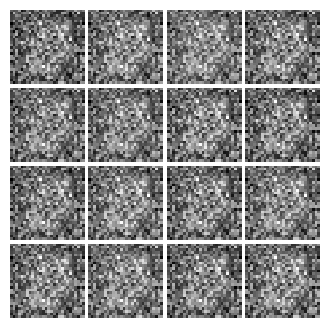

Epoch: 0, Iter: 80, D: 0.9403, G:1.848


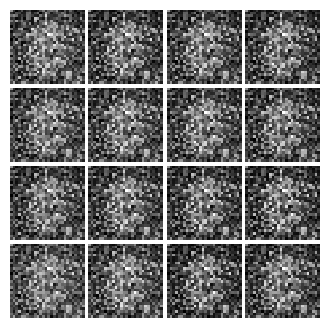

Epoch: 0, Iter: 100, D: 1.409, G:1.429


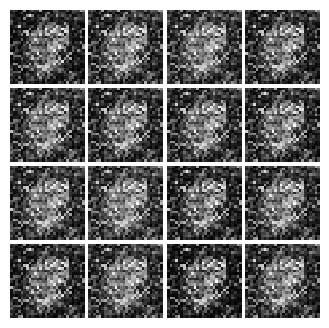

Epoch: 0, Iter: 120, D: 1.417, G:1.447


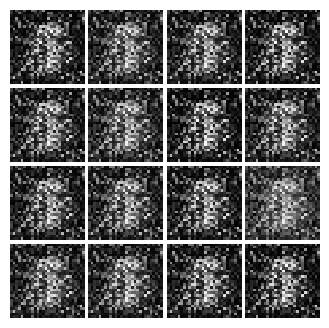

Epoch: 0, Iter: 140, D: 1.655, G:0.4434


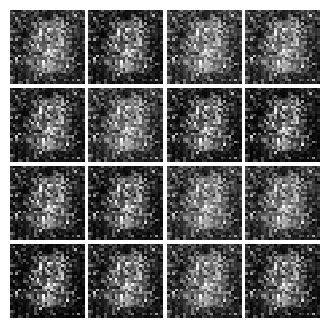

Epoch: 0, Iter: 160, D: 1.371, G:1.41


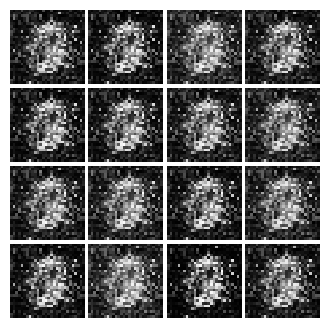

Epoch: 0, Iter: 180, D: 0.8604, G:2.357


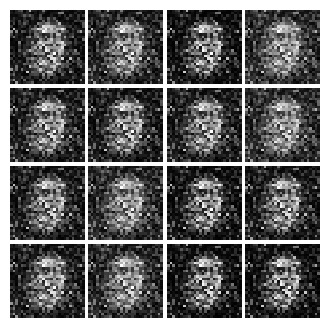

Epoch: 0, Iter: 200, D: 0.8762, G:1.709


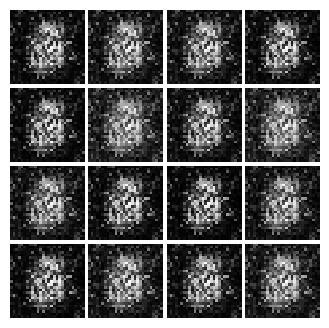

Epoch: 0, Iter: 220, D: 1.394, G:0.9771


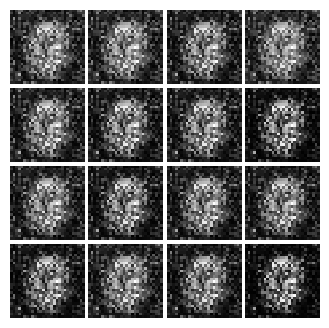

Epoch: 0, Iter: 240, D: 1.34, G:1.359


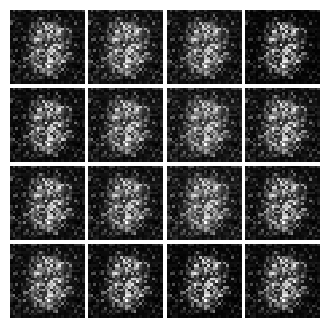

Epoch: 0, Iter: 260, D: 1.062, G:1.451


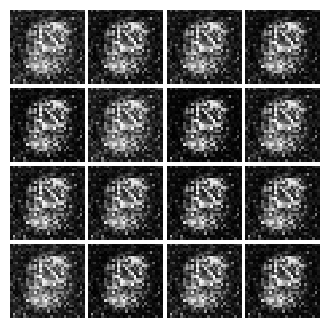

Epoch: 0, Iter: 280, D: 1.711, G:0.7331


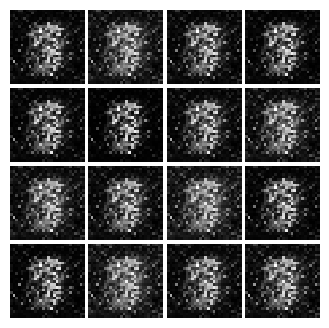

Epoch: 0, Iter: 300, D: 1.283, G:1.636


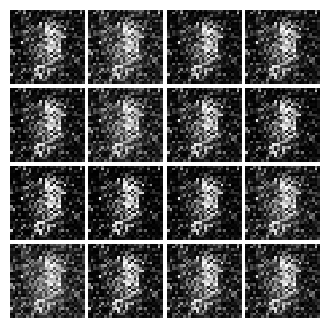

Epoch: 0, Iter: 320, D: 1.363, G:1.217


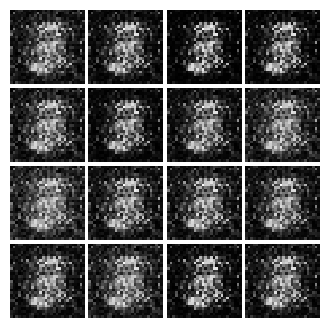

Epoch: 0, Iter: 340, D: 1.041, G:1.205


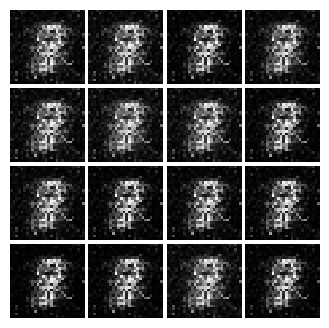

Epoch: 0, Iter: 360, D: 1.059, G:1.241


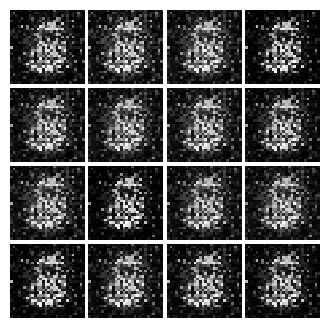

Epoch: 0, Iter: 380, D: 1.156, G:1.953


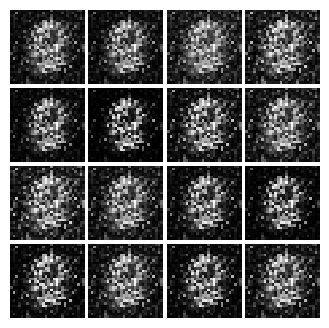

Epoch: 0, Iter: 400, D: 0.6539, G:2.784


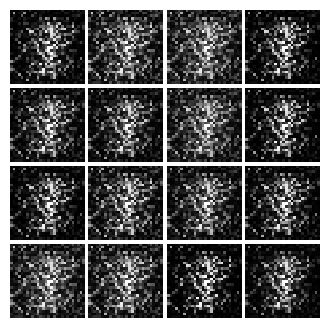

Epoch: 0, Iter: 420, D: 0.7925, G:1.75


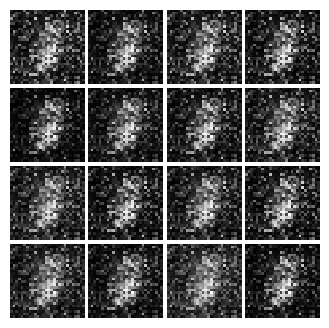

Epoch: 0, Iter: 440, D: 1.073, G:3.13


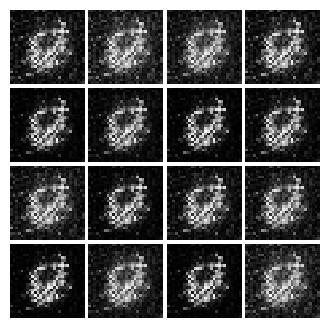

Epoch: 0, Iter: 460, D: 0.8327, G:1.715


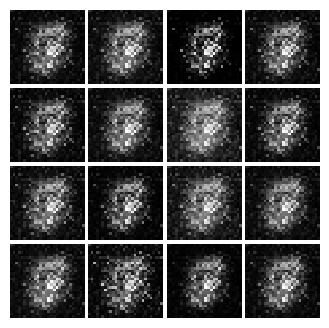

Epoch: 1, Iter: 480, D: 1.067, G:1.305


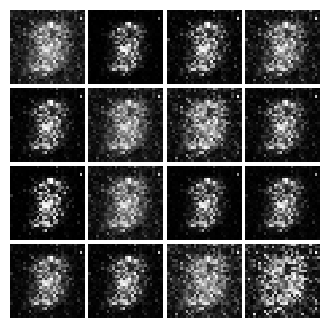

Epoch: 1, Iter: 500, D: 1.14, G:1.358


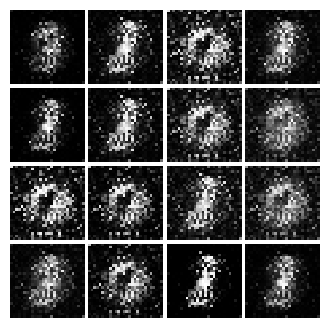

Epoch: 1, Iter: 520, D: 1.041, G:0.9282


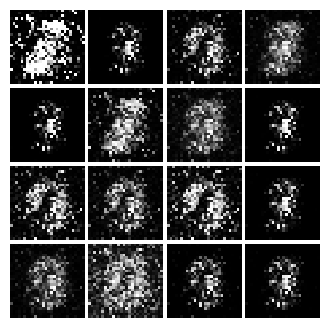

Epoch: 1, Iter: 540, D: 1.13, G:1.319


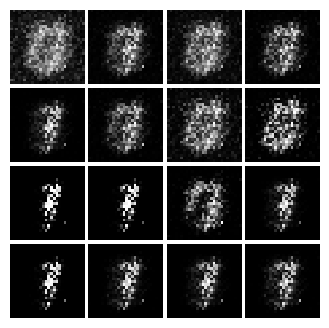

Epoch: 1, Iter: 560, D: 1.12, G:0.9223


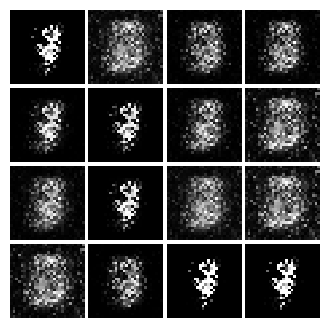

Epoch: 1, Iter: 580, D: 1.078, G:1.64


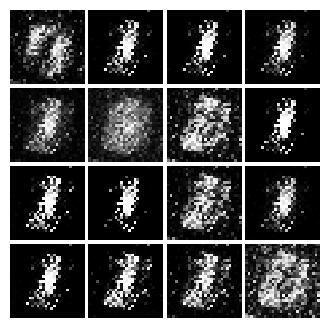

Epoch: 1, Iter: 600, D: 0.8152, G:1.932


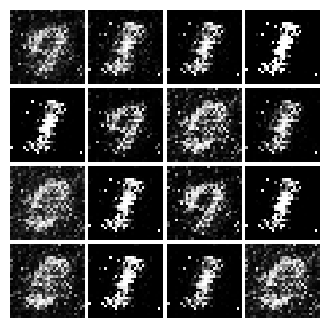

Epoch: 1, Iter: 620, D: 1.045, G:0.8194


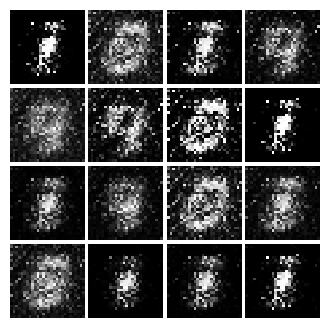

Epoch: 1, Iter: 640, D: 0.8889, G:1.58


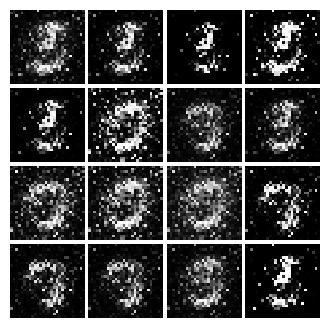

Epoch: 1, Iter: 660, D: 0.9688, G:1.423


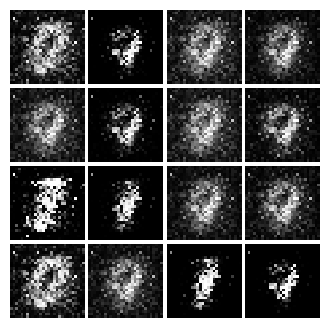

Epoch: 1, Iter: 680, D: 2.57, G:0.9866


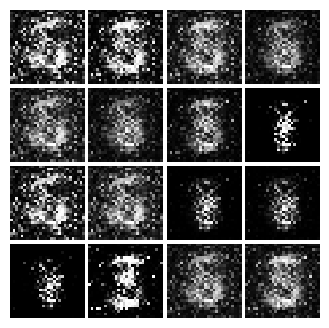

Epoch: 1, Iter: 700, D: 0.913, G:2.123


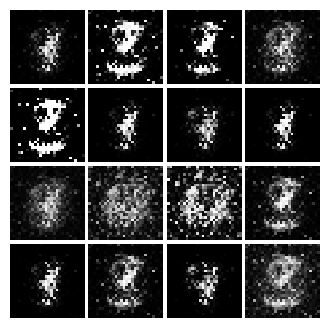

Epoch: 1, Iter: 720, D: 1.144, G:0.74


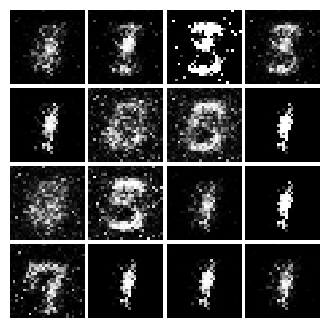

Epoch: 1, Iter: 740, D: 0.9484, G:1.399


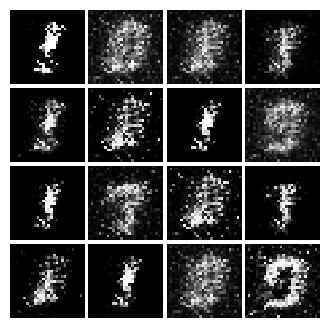

Epoch: 1, Iter: 760, D: 1.75, G:0.6781


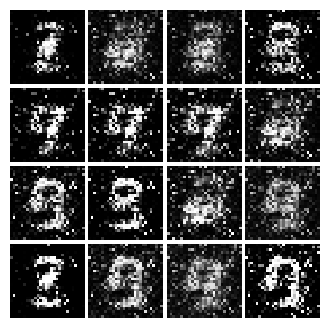

Epoch: 1, Iter: 780, D: 1.079, G:1.582


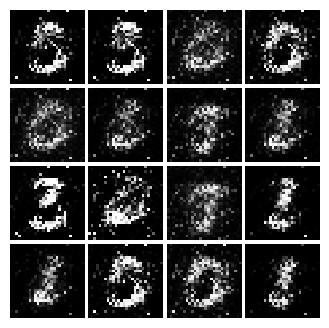

Epoch: 1, Iter: 800, D: 1.011, G:1.275


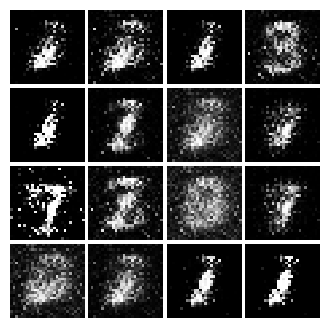

Epoch: 1, Iter: 820, D: 0.964, G:1.14


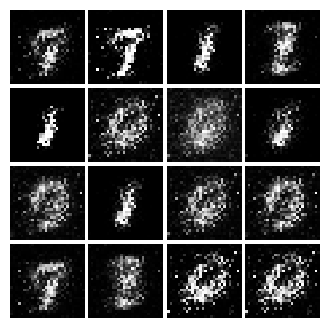

Epoch: 1, Iter: 840, D: 1.187, G:1.32


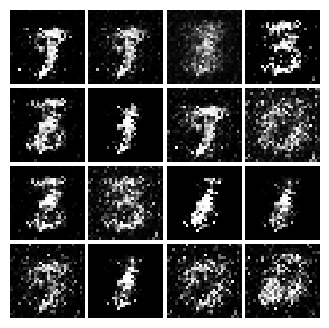

Epoch: 1, Iter: 860, D: 1.24, G:1.668


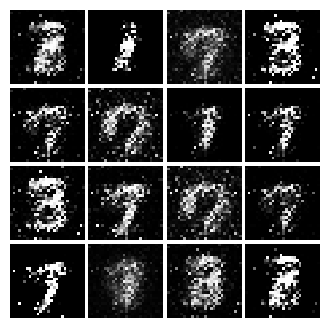

Epoch: 1, Iter: 880, D: 1.178, G:1.186


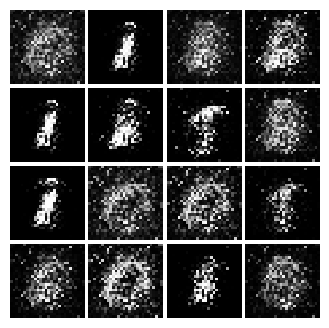

Epoch: 1, Iter: 900, D: 1.21, G:1.454


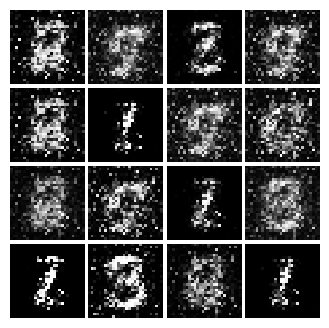

Epoch: 1, Iter: 920, D: 1.256, G:0.7994


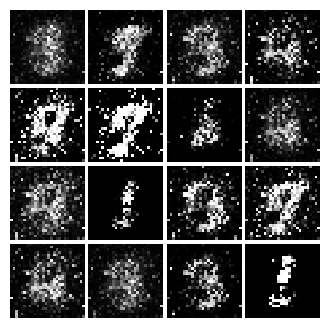

Epoch: 2, Iter: 940, D: 1.273, G:1.07


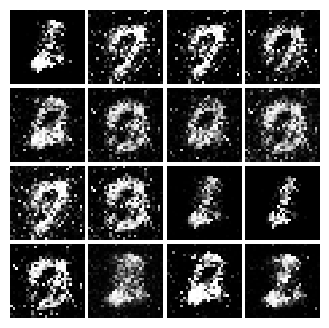

Epoch: 2, Iter: 960, D: 1.078, G:0.9004


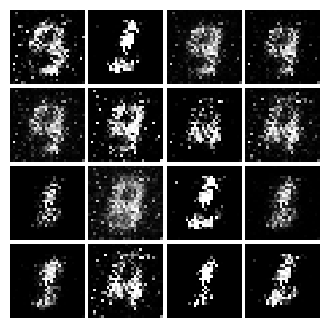

Epoch: 2, Iter: 980, D: 1.232, G:1.35


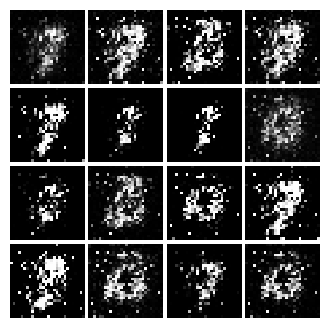

Epoch: 2, Iter: 1000, D: 0.955, G:1.913


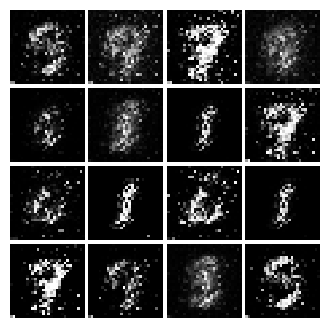

Epoch: 2, Iter: 1020, D: 1.133, G:1.462


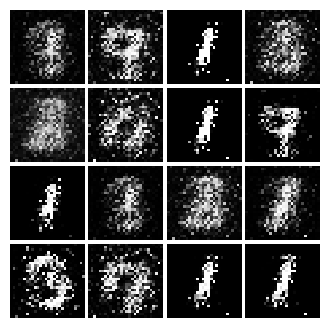

Epoch: 2, Iter: 1040, D: 1.049, G:1.193


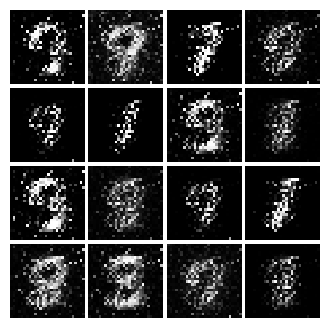

Epoch: 2, Iter: 1060, D: 0.9816, G:1.082


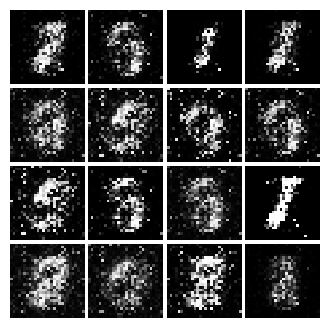

Epoch: 2, Iter: 1080, D: 2.436, G:0.1891


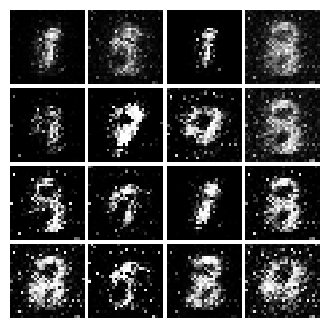

Epoch: 2, Iter: 1100, D: 0.9932, G:1.592


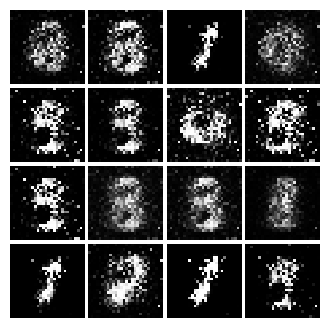

Epoch: 2, Iter: 1120, D: 1.301, G:1.677


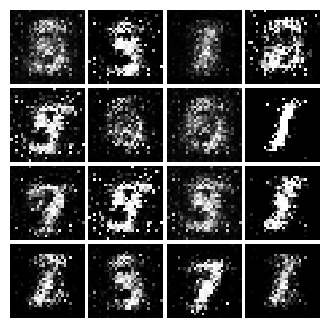

Epoch: 2, Iter: 1140, D: 1.396, G:1.587


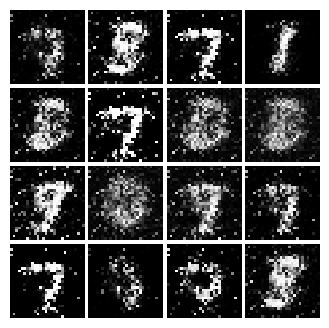

Epoch: 2, Iter: 1160, D: 1.215, G:1.387


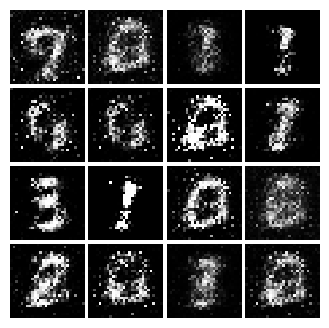

Epoch: 2, Iter: 1180, D: 1.264, G:1.042


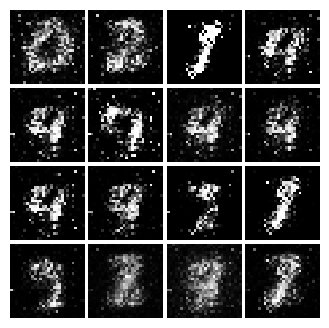

Epoch: 2, Iter: 1200, D: 1.485, G:1.061


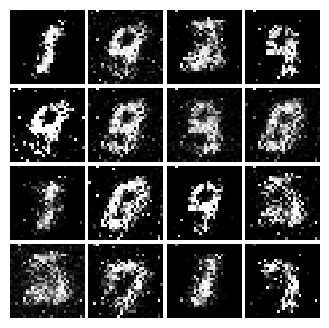

Epoch: 2, Iter: 1220, D: 1.031, G:1.896


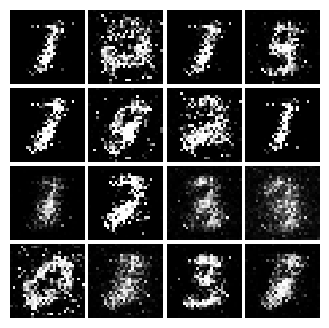

Epoch: 2, Iter: 1240, D: 1.002, G:1.081


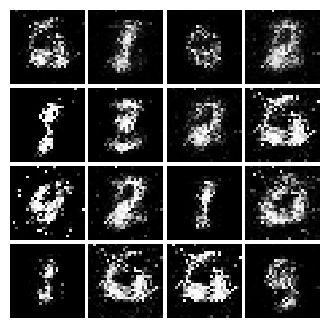

Epoch: 2, Iter: 1260, D: 1.294, G:1.151


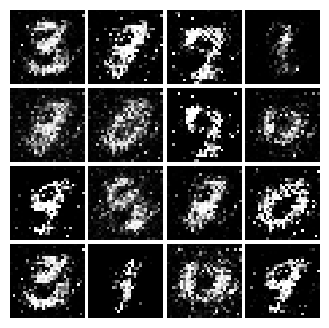

Epoch: 2, Iter: 1280, D: 1.311, G:0.9675


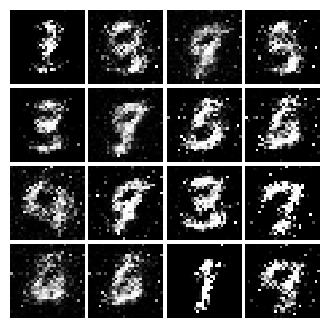

Epoch: 2, Iter: 1300, D: 1.202, G:0.9702


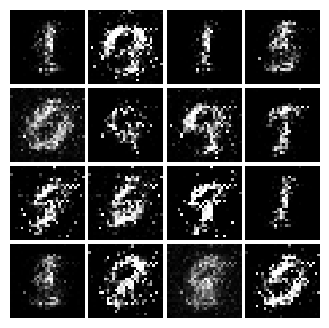

Epoch: 2, Iter: 1320, D: 1.348, G:0.9032


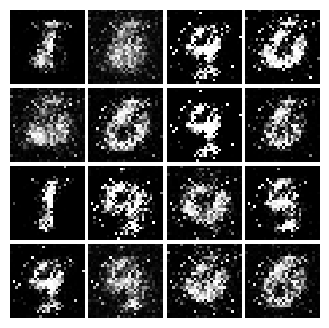

Epoch: 2, Iter: 1340, D: 1.274, G:1.391


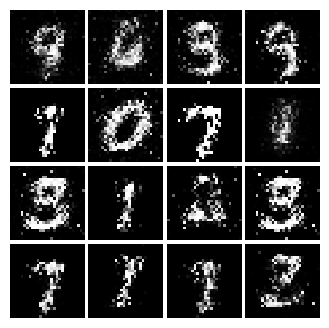

Epoch: 2, Iter: 1360, D: 1.28, G:0.8767


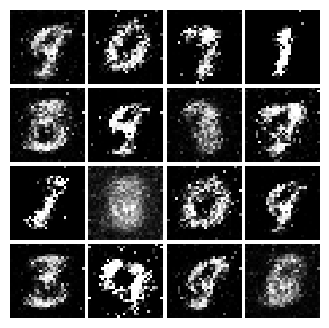

Epoch: 2, Iter: 1380, D: 1.162, G:0.8464


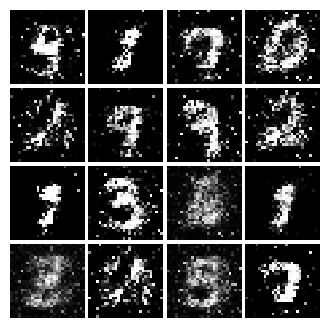

Epoch: 2, Iter: 1400, D: 1.143, G:1.238


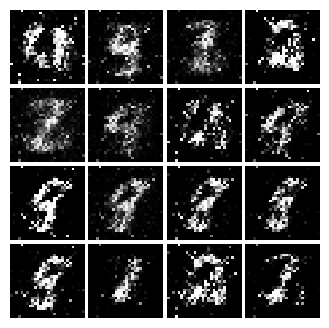

Epoch: 3, Iter: 1420, D: 1.209, G:0.9354


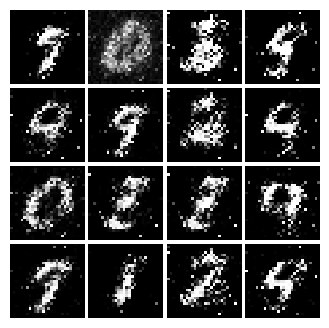

Epoch: 3, Iter: 1440, D: 1.077, G:1.074


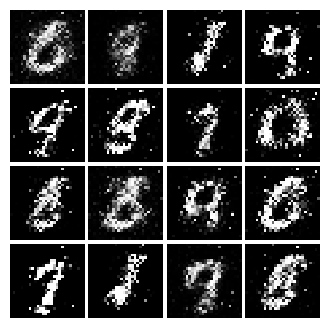

Epoch: 3, Iter: 1460, D: 1.85, G:3.121


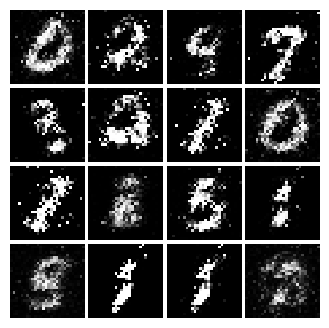

Epoch: 3, Iter: 1480, D: 1.22, G:0.9415


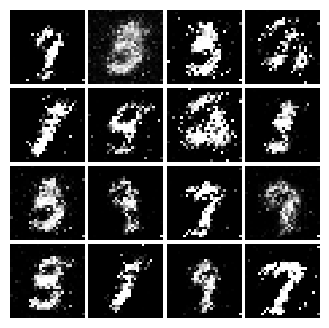

Epoch: 3, Iter: 1500, D: 1.226, G:0.896


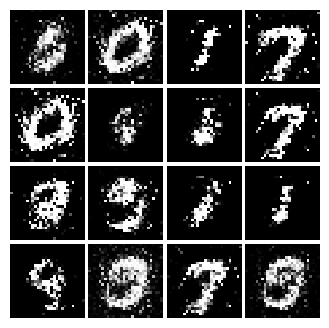

Epoch: 3, Iter: 1520, D: 1.224, G:1.115


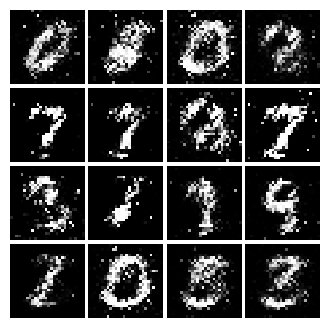

Epoch: 3, Iter: 1540, D: 1.197, G:1.459


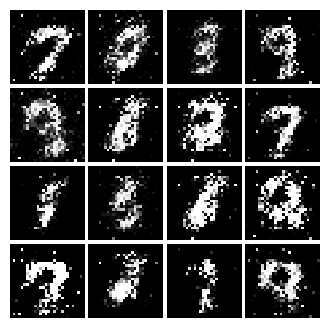

Epoch: 3, Iter: 1560, D: 1.151, G:1.121


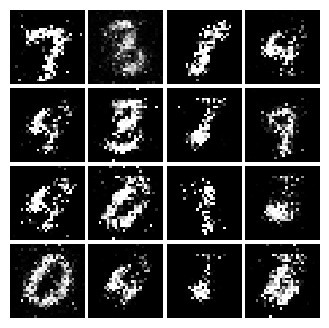

Epoch: 3, Iter: 1580, D: 1.134, G:1.039


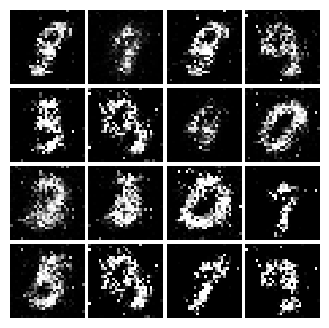

Epoch: 3, Iter: 1600, D: 1.218, G:0.9393


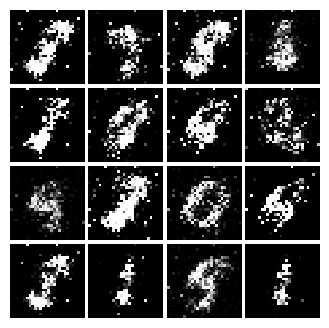

Epoch: 3, Iter: 1620, D: 0.9777, G:1.196


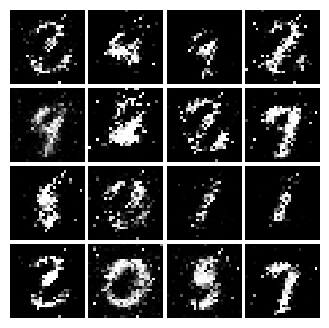

Epoch: 3, Iter: 1640, D: 1.474, G:2.122


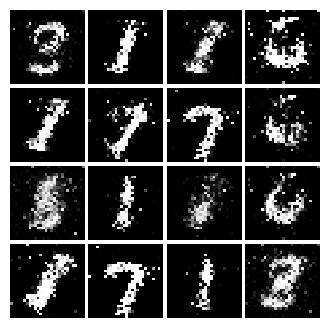

Epoch: 3, Iter: 1660, D: 1.298, G:1.246


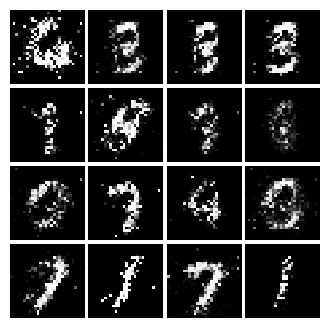

Epoch: 3, Iter: 1680, D: 1.093, G:1.118


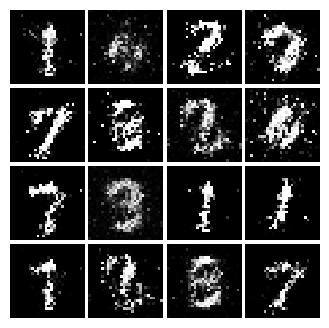

Epoch: 3, Iter: 1700, D: 1.237, G:1.069


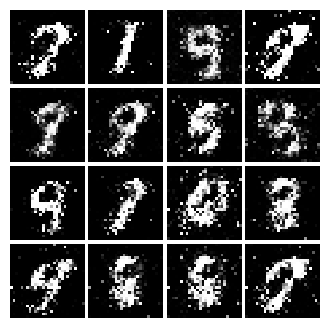

Epoch: 3, Iter: 1720, D: 1.108, G:1.536


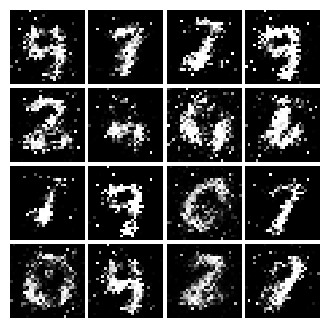

Epoch: 3, Iter: 1740, D: 1.209, G:0.8656


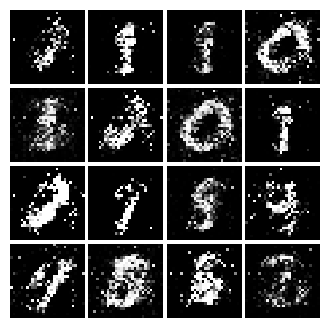

Epoch: 3, Iter: 1760, D: 1.69, G:0.9569


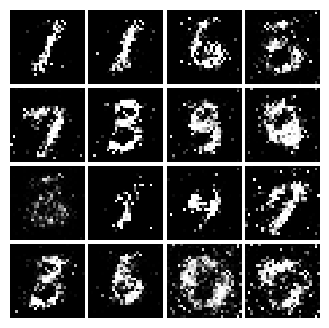

Epoch: 3, Iter: 1780, D: 1.155, G:1.038


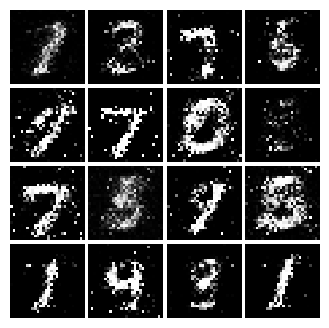

Epoch: 3, Iter: 1800, D: 1.165, G:0.9441


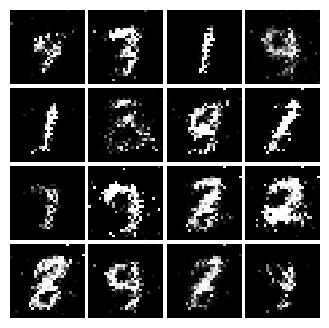

Epoch: 3, Iter: 1820, D: 1.38, G:0.9256


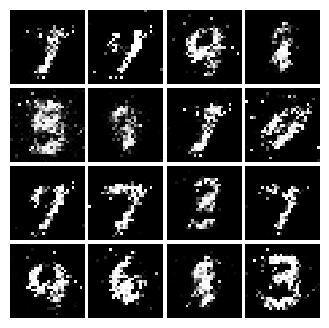

Epoch: 3, Iter: 1840, D: 1.22, G:1.015


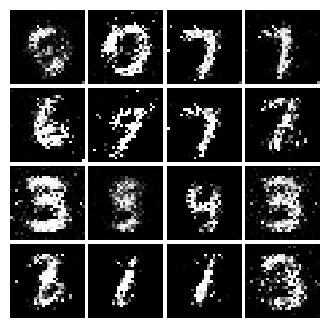

Epoch: 3, Iter: 1860, D: 1.331, G:1.399


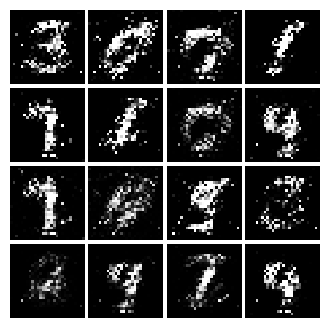

Epoch: 4, Iter: 1880, D: 1.238, G:0.9888


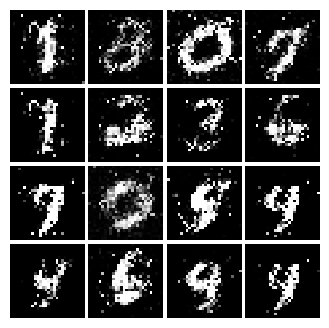

Epoch: 4, Iter: 1900, D: 1.214, G:1.119


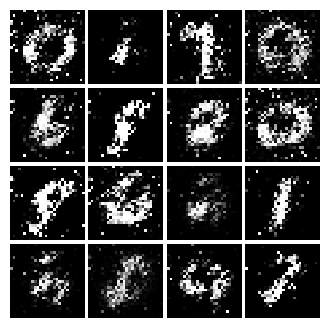

Epoch: 4, Iter: 1920, D: 1.225, G:0.9568


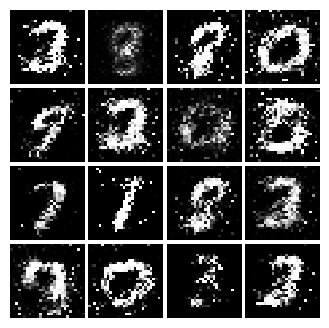

Epoch: 4, Iter: 1940, D: 1.225, G:0.9633


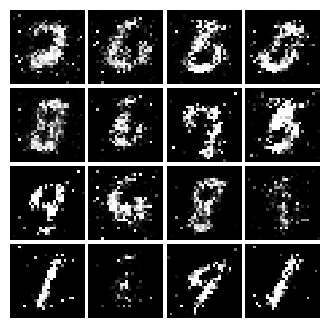

Epoch: 4, Iter: 1960, D: 1.62, G:0.3771


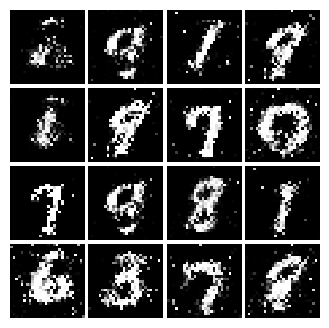

Epoch: 4, Iter: 1980, D: 1.245, G:1.007


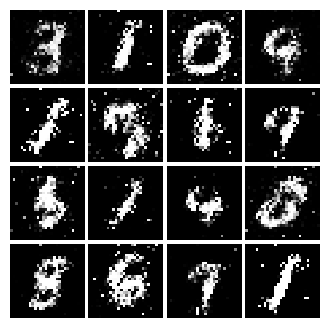

Epoch: 4, Iter: 2000, D: 1.354, G:0.7427


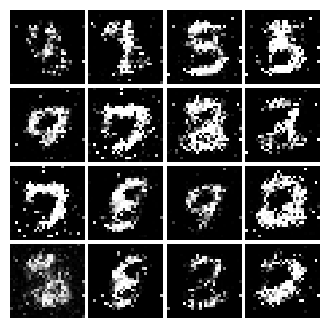

Epoch: 4, Iter: 2020, D: 1.356, G:0.939


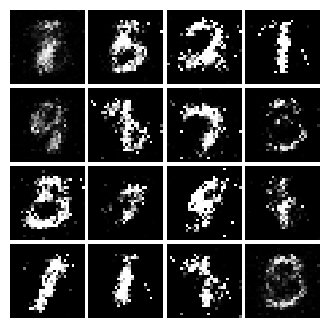

Epoch: 4, Iter: 2040, D: 1.403, G:0.7768


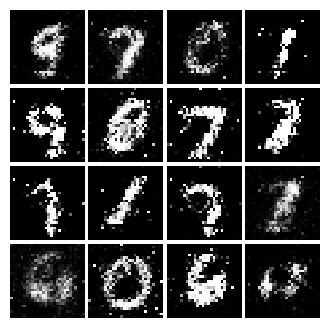

Epoch: 4, Iter: 2060, D: 1.186, G:0.938


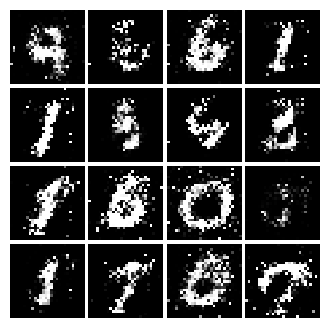

Epoch: 4, Iter: 2080, D: 1.377, G:1.14


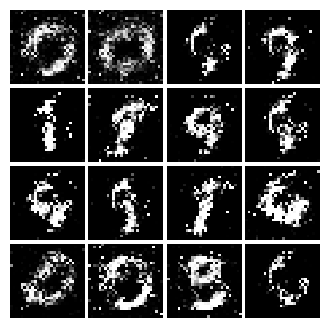

Epoch: 4, Iter: 2100, D: 1.182, G:0.701


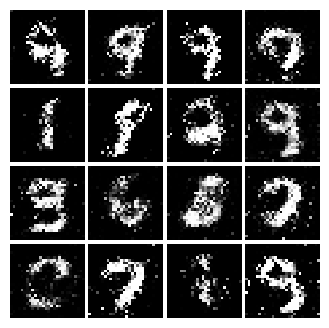

Epoch: 4, Iter: 2120, D: 1.254, G:0.892


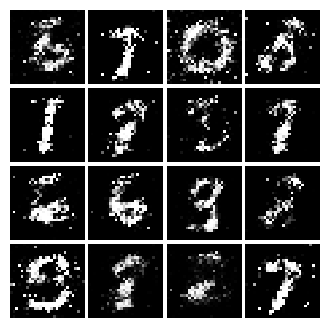

Epoch: 4, Iter: 2140, D: 1.444, G:0.9296


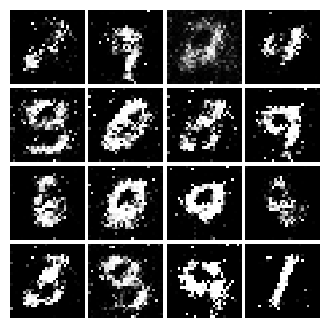

Epoch: 4, Iter: 2160, D: 1.323, G:0.8377


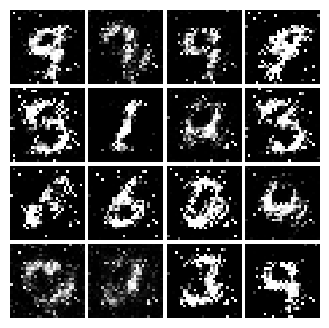

Epoch: 4, Iter: 2180, D: 1.25, G:0.8596


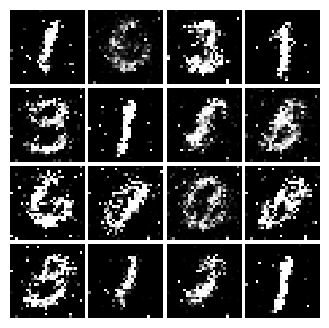

Epoch: 4, Iter: 2200, D: 1.123, G:0.9379


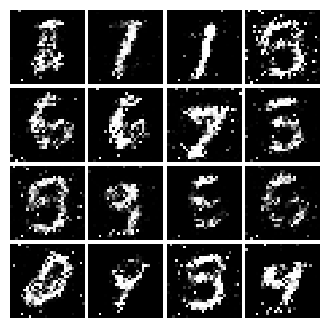

Epoch: 4, Iter: 2220, D: 1.145, G:1.025


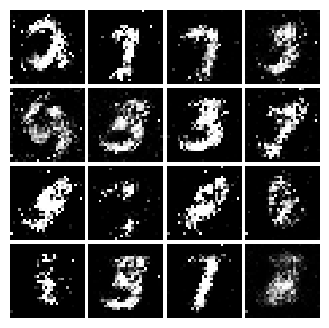

Epoch: 4, Iter: 2240, D: 1.276, G:0.8139


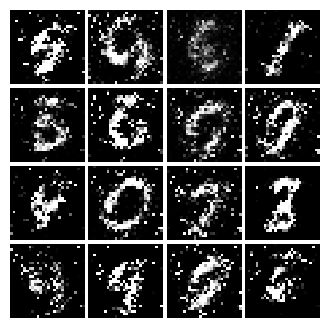

Epoch: 4, Iter: 2260, D: 1.415, G:1.058


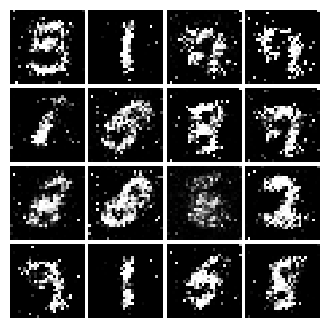

Epoch: 4, Iter: 2280, D: 1.237, G:0.968


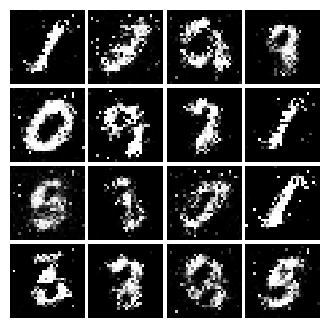

Epoch: 4, Iter: 2300, D: 1.216, G:0.9211


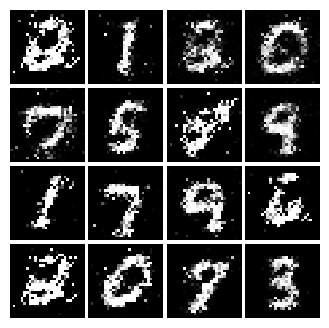

Epoch: 4, Iter: 2320, D: 1.23, G:0.9731


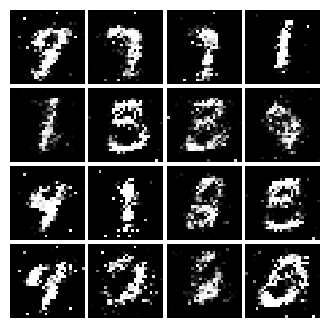

Epoch: 4, Iter: 2340, D: 1.102, G:1.12


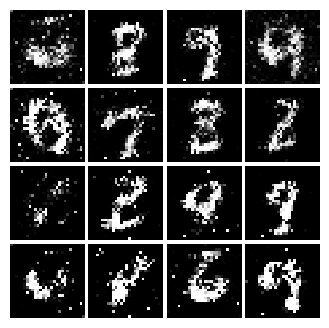

Epoch: 5, Iter: 2360, D: 1.207, G:1.121


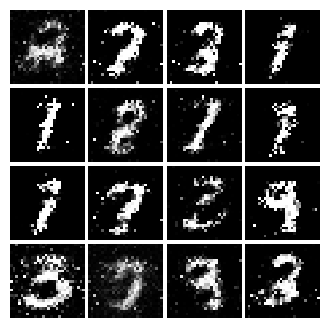

Epoch: 5, Iter: 2380, D: 1.316, G:0.9716


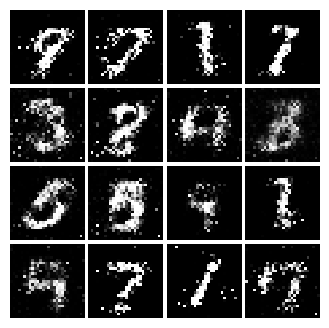

Epoch: 5, Iter: 2400, D: 1.214, G:0.8721


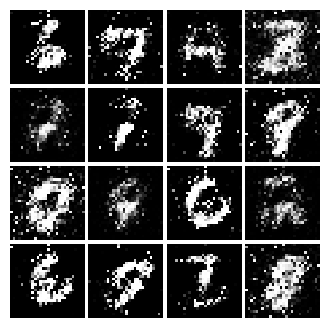

Epoch: 5, Iter: 2420, D: 1.117, G:1.046


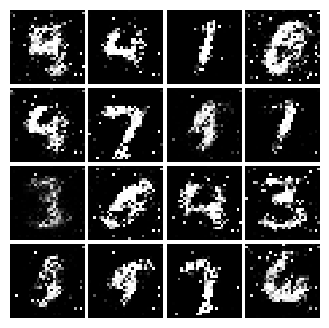

Epoch: 5, Iter: 2440, D: 1.333, G:0.9218


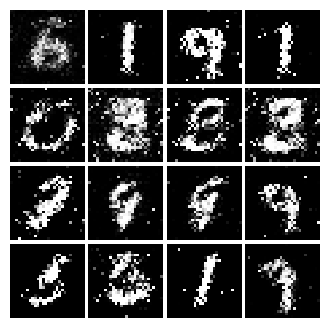

Epoch: 5, Iter: 2460, D: 1.212, G:1.064


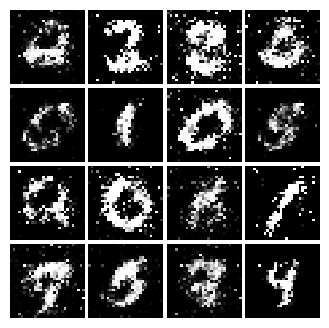

Epoch: 5, Iter: 2480, D: 1.105, G:1.019


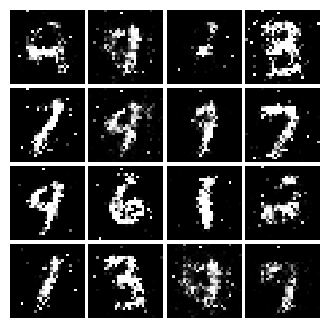

Epoch: 5, Iter: 2500, D: 1.135, G:1.081


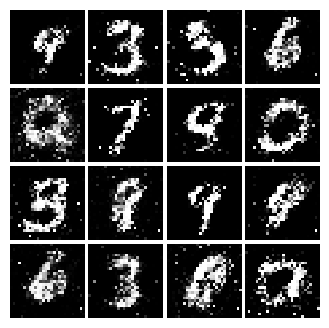

Epoch: 5, Iter: 2520, D: 1.411, G:0.8286


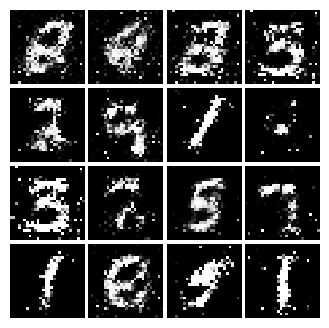

Epoch: 5, Iter: 2540, D: 1.37, G:0.8772


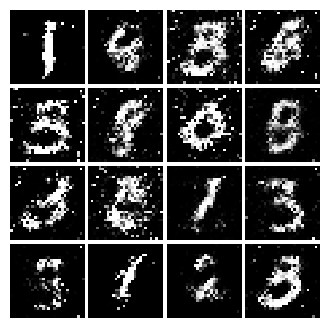

Epoch: 5, Iter: 2560, D: 1.271, G:0.9938


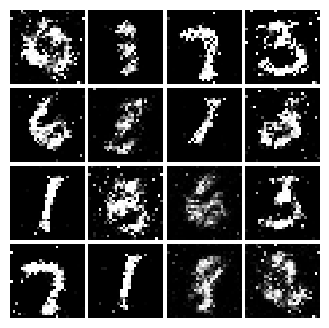

Epoch: 5, Iter: 2580, D: 1.318, G:0.8037


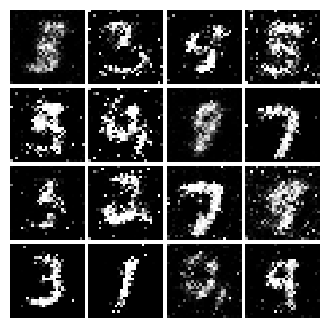

Epoch: 5, Iter: 2600, D: 1.422, G:0.6957


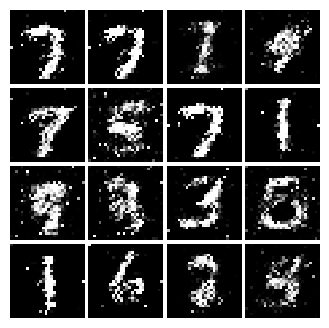

Epoch: 5, Iter: 2620, D: 1.265, G:0.864


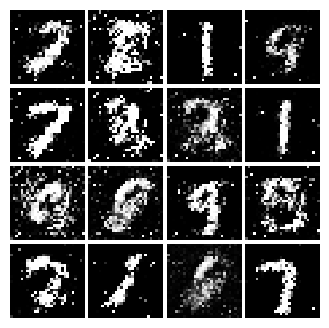

Epoch: 5, Iter: 2640, D: 1.364, G:0.9519


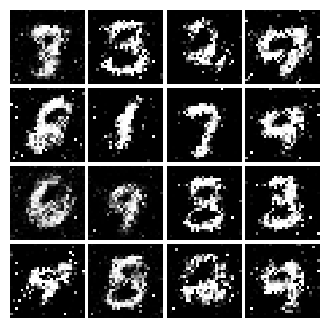

Epoch: 5, Iter: 2660, D: 1.272, G:0.9024


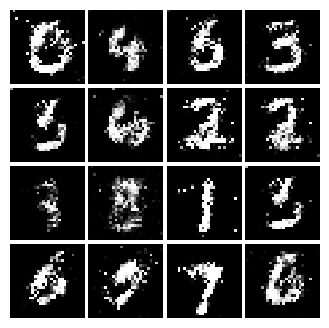

Epoch: 5, Iter: 2680, D: 1.476, G:0.9214


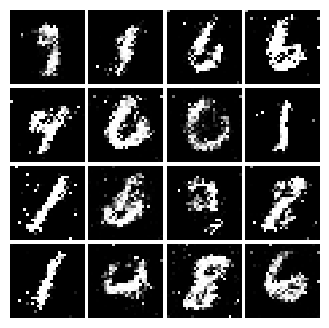

Epoch: 5, Iter: 2700, D: 1.378, G:0.9003


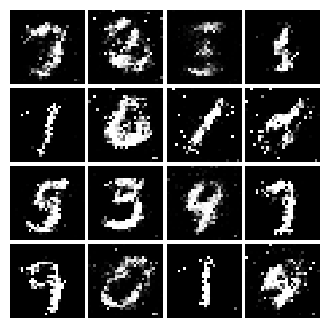

Epoch: 5, Iter: 2720, D: 1.239, G:1.041


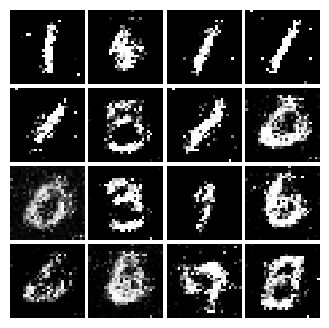

Epoch: 5, Iter: 2740, D: 1.308, G:0.8558


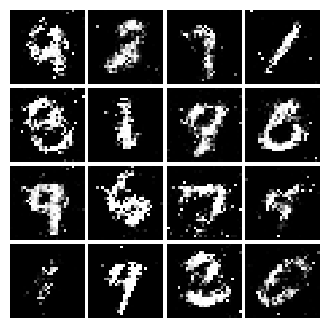

Epoch: 5, Iter: 2760, D: 1.311, G:0.7761


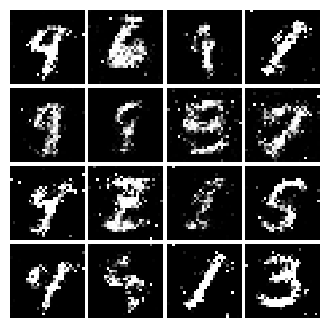

Epoch: 5, Iter: 2780, D: 1.265, G:0.8755


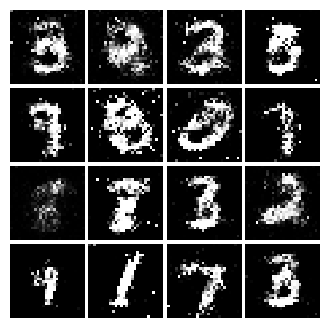

Epoch: 5, Iter: 2800, D: 1.188, G:0.8455


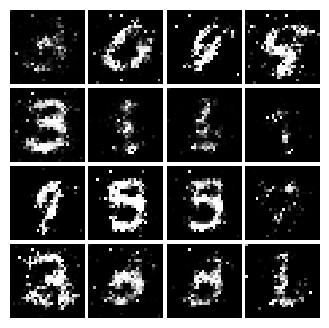

Epoch: 6, Iter: 2820, D: 1.344, G:0.7781


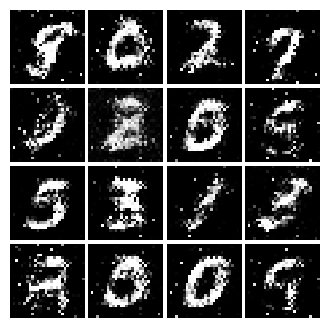

Epoch: 6, Iter: 2840, D: 1.249, G:0.9574


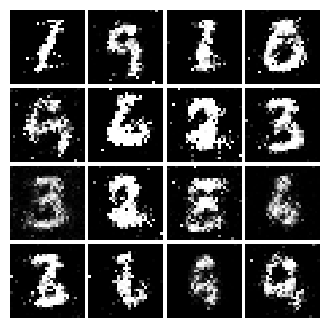

Epoch: 6, Iter: 2860, D: 1.304, G:0.9246


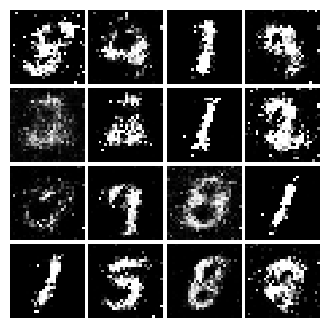

Epoch: 6, Iter: 2880, D: 1.218, G:0.817


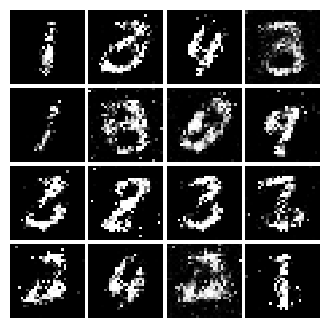

Epoch: 6, Iter: 2900, D: 1.268, G:0.7695


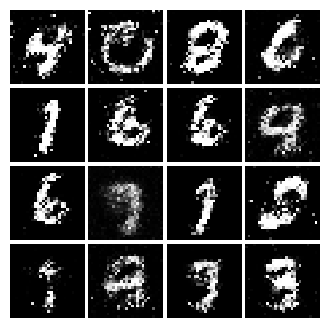

Epoch: 6, Iter: 2920, D: 1.297, G:0.818


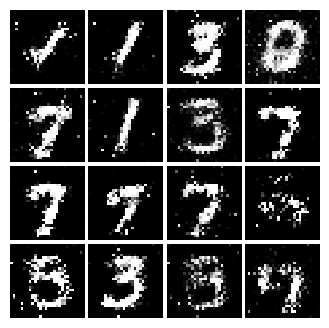

Epoch: 6, Iter: 2940, D: 1.455, G:0.8169


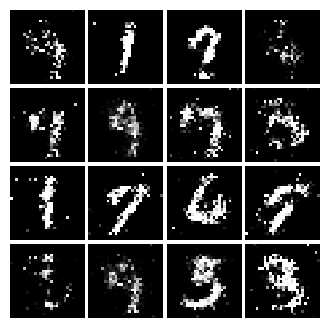

Epoch: 6, Iter: 2960, D: 1.312, G:0.805


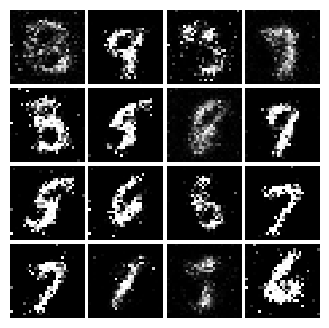

Epoch: 6, Iter: 2980, D: 1.426, G:0.845


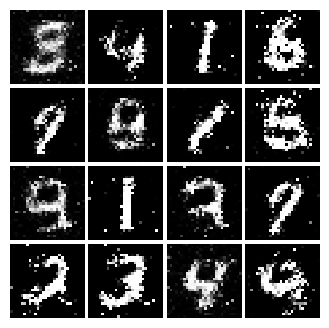

Epoch: 6, Iter: 3000, D: 1.332, G:0.9711


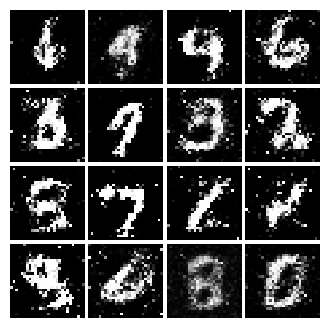

Epoch: 6, Iter: 3020, D: 1.319, G:0.7713


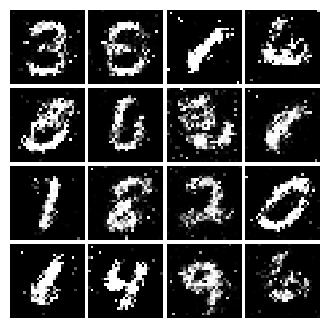

Epoch: 6, Iter: 3040, D: 1.39, G:0.9


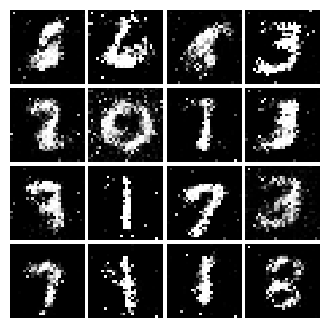

Epoch: 6, Iter: 3060, D: 1.389, G:0.7473


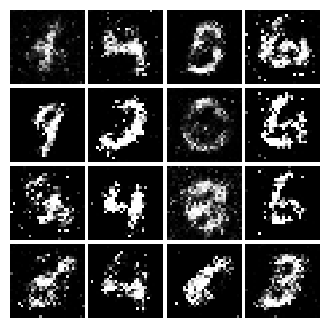

Epoch: 6, Iter: 3080, D: 1.294, G:0.7913


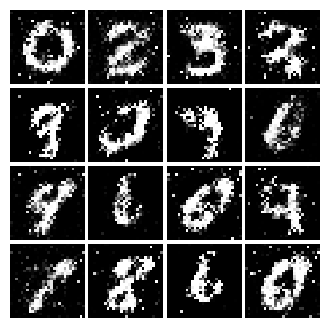

Epoch: 6, Iter: 3100, D: 1.284, G:0.847


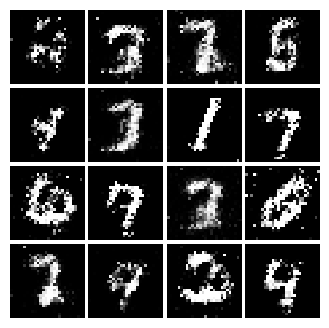

Epoch: 6, Iter: 3120, D: 1.296, G:0.8102


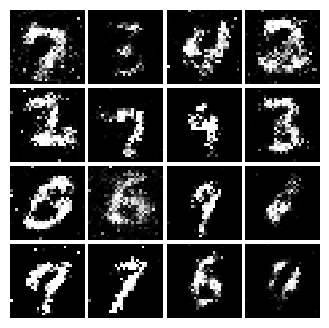

Epoch: 6, Iter: 3140, D: 1.338, G:0.9287


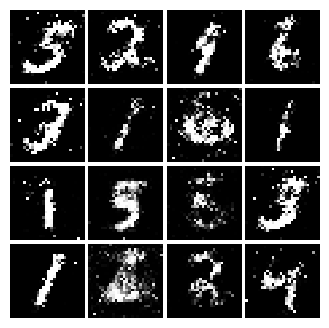

Epoch: 6, Iter: 3160, D: 1.325, G:0.8057


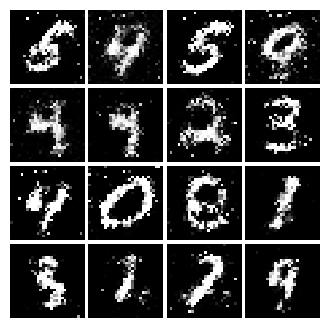

Epoch: 6, Iter: 3180, D: 1.33, G:0.755


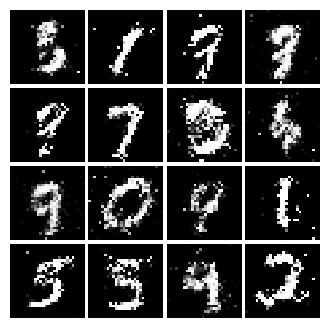

Epoch: 6, Iter: 3200, D: 1.322, G:0.9208


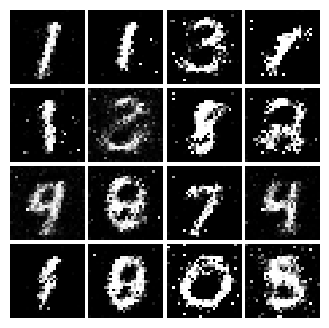

Epoch: 6, Iter: 3220, D: 1.235, G:0.8693


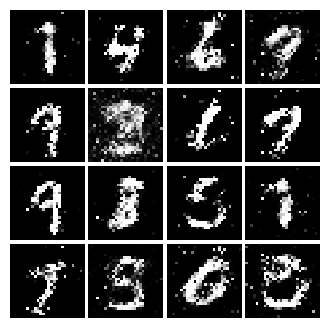

Epoch: 6, Iter: 3240, D: 1.253, G:0.8592


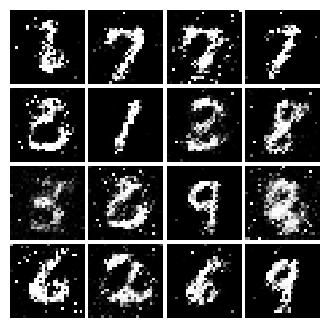

Epoch: 6, Iter: 3260, D: 1.341, G:1.23


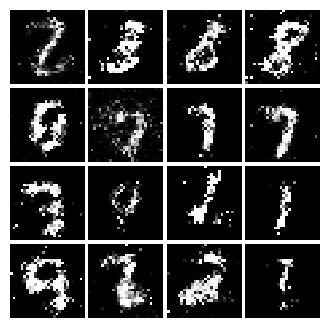

Epoch: 6, Iter: 3280, D: 1.414, G:0.9237


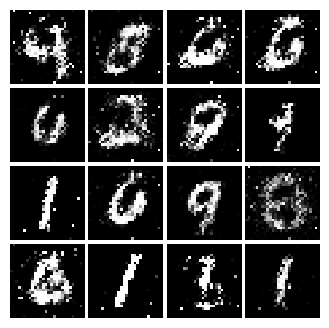

Final images


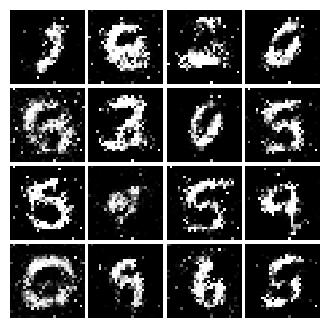

In [17]:
# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

Sample images


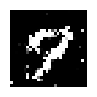

In [22]:
s1=sample_noise(1, 96)
# generated images
G_sample = G(s1)
print('Sample images')
show_images(G_sample[:16])
plt.show()